In [1]:
MDtrajs_dir="./MDtrajs/"
Featurization_dir="./Featurization/"
FSelection_dir = "./FSel/"
GMRQ_dir="./GMRQ/"
MicroMSM_dir='./MicroMSM/tica/'
MacroMSM_dir='./MacroMSM/tica/'

### tICA Micro Markov State Model

In [2]:
import numpy as np
import multiprocessing
from joblib import Parallel, delayed
from msmbuilder.decomposition import tICA
from msmbuilder.msm import MarkovStateModel
from msmbuilder.cluster import KMeans, MiniBatchKMeans, KCenters

In [ ]:
oasis_trajs = np.load(FSelection_dir + 'oasis_trajs.npy', allow_pickle=True)

tica = tICA(n_components=4, lag_time=200, kinetic_mapping=True)
tica_trajs = tica.fit_transform(oasis_trajs)
tica_trajs = np.array(tica_trajs, dtype=object)
np.save(MicroMSM_dir + 'tica_trajs.npy', tica_trajs)

cluster = KCenters(n_clusters=200, random_state=42)
clustered_trajs = cluster.fit_transform(tica_trajs)
clustered_trajs = np.array(clustered_trajs, dtype=object)
np.save(MicroMSM_dir + 'clustered_trajs.npy', clustered_trajs)

In [ ]:
# Construct the microstate MSM
msm = MarkovStateModel(n_timescales=10, lag_time=500, ergodic_cutoff='off', 
                       reversible_type='transpose', verbose=False)
msm.fit(clustered_trajs)
micro_TPM = msm.transmat_
states_idx = np.argsort(msm.populations_)[:-9:-1]

np.save(MicroMSM_dir + '500_lt_micro_TPM.npy', micro_TPM)    
np.savetxt(MicroMSM_dir + 'states_idx.txt', states_idx, fmt='%d')    

In [3]:
def bootstrapMSM(trajs, lagtime, n_timescales, n_RP, RP_idx, n_states, num_samples_per_run):
    
    bootstrap_indices = np.random.choice(range(len(trajs)), 
                                         size=num_samples_per_run, replace=True)
    bootstrap_trajs = [trajs[i] for i in bootstrap_indices]
    
    states_set = set(np.concatenate(bootstrap_trajs))
    reference_set = set(np.arange(n_states))
    miss_states_idx = sorted(list(reference_set - states_set))
    
    bootstrap_ITS = np.zeros((len(lagtime), n_timescales))
    bootstrap_RP = np.zeros((len(lagtime), n_RP))
    
    for i in range(len(lagtime)):
        msm = MarkovStateModel(n_timescales=n_timescales, lag_time=lagtime[i], ergodic_cutoff='off', 
                               reversible_type='transpose', verbose=False)
        msm.fit(bootstrap_trajs)        
        bootstrap_ITS[i] = msm.timescales_
        RP_all = np.diag(msm.transmat_)
        if len(miss_states_idx) != 0:
            for index in miss_states_idx:
                RP_all = np.insert(RP_all, index, 0)
#        print("The length of resident probability is %d"%(len(RP_all)))
        bootstrap_RP[i] = RP_all[RP_idx]
    return bootstrap_ITS, bootstrap_RP

def CK_test(lag, TPM, delta_t=0.2, length=1500):
    n_micro = len(TPM)
    TPM_micro = np.zeros((length//lag, n_micro, n_micro))
    TPM_time = np.zeros(length//lag)
    TPM_micro[0] = TPM
    for i in range(len(TPM_micro)):
        TPM_micro[i] = np.linalg.matrix_power(TPM_micro[0], i+1)
        TPM_time[i] = lag * (i+1) * delta_t 
    return TPM_time, TPM_micro

num_runs = 50
num_samples_per_run = 150
lagtime = np.arange(5,1501,5)
n_timescales = 10
n_RP = 8

In [ ]:
bootstrap_ITS = np.memmap(MicroMSM_dir + "bootstrap_ITS.npy", dtype=np.float64, 
                          mode="w+", shape=(num_runs, len(lagtime), n_timescales))
bootstrap_RP = np.memmap(MicroMSM_dir + "bootstrap_RP.npy", dtype=np.float64, 
                          mode="w+", shape=(num_runs, len(lagtime), n_RP))

def Process(run):
    result1, result2 = bootstrapMSM(trajs=clustered_trajs, lagtime=lagtime, 
                                    n_timescales=n_timescales, n_RP=n_RP, 
                                    RP_idx=states_idx, n_states=200, 
                                    num_samples_per_run=num_samples_per_run)
    bootstrap_ITS[run] = result1
    bootstrap_RP[run] = result2
    
Parallel(n_jobs=5)(delayed(Process)(run = i) for i in range(num_runs))  

In [4]:
bootstrap_RP = np.array(np.memmap(MicroMSM_dir + "bootstrap_RP.npy", 
                                  dtype=np.float64, mode="r", shape=(50, 300, 8)))
bootstrap_ITS = np.array(np.memmap(MicroMSM_dir + "bootstrap_ITS.npy", dtype=np.float64, 
                          mode="r", shape=(50, 300, 10)))
list_indice = np.loadtxt(MicroMSM_dir + 'states_idx.txt', dtype=int)

delta_t = 0.2
MSM_time, MSM_TPM = CK_test(lag=500, delta_t=0.2,
                             TPM=np.load(MicroMSM_dir + "500_lt_micro_TPM.npy"))

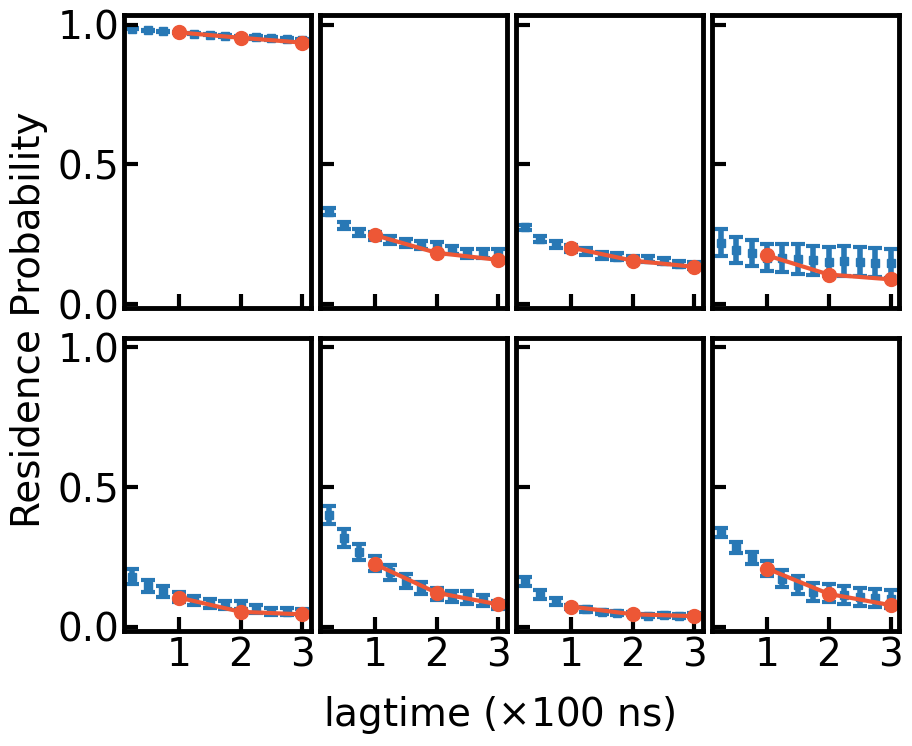

In [18]:
from matplotlib import pyplot as plt
color_1 = '#2878B5'
color_2 = '#ed5736'
RP_mean = np.mean(bootstrap_RP, axis=0)
RP_std = np.std(bootstrap_RP, axis=0)

plt.rcParams['font.size'] = 28
fig, axes = plt.subplots(2, 4, figsize=(10, 8), sharex=True, sharey=True)
for i in range(8):
    ax = axes[int(i/4), int(i%4)]
    ax.errorbar(np.arange(25,301,25), RP_mean[24::25,i], yerr=RP_std[24::25,i],
                fmt='s', capsize=5, capthick=3,
                elinewidth=4, ecolor=color_1, color=color_1,
                zorder=0, linewidth=3)
    ax.plot(MSM_time, MSM_TPM[:,list_indice[i],list_indice[i]], linewidth=3,
            zorder=1, color=color_2)
    ax.scatter(MSM_time, MSM_TPM[:,list_indice[i],list_indice[i]], s=100, zorder=2,
               c=color_2)
    ax.tick_params(axis='both', direction='in', width=3, length=10)
    ax.set_xticks(ticks=[100, 200, 300], labels=[1, 2, 3])
#     ax.text(300, 0.8, 'State %d'%(i+1), ha='right',va='top')
    for spine in ax.spines.values():
        spine.set_linewidth(3.5)
        
fig.subplots_adjust(wspace=0.4, hspace=0.2)
fig.text(0.5, 0.005, 'lagtime ($\\times$100 ns)', ha='center', va='center')
fig.text(0.03, 0.5, "Residence Probability", ha='center', va='center', rotation=90)
plt.errorbar([], [], yerr=[], color=color_1, label='MD', fmt='s',
             markersize=20, elinewidth=3, capsize=3)
plt.plot([], [], label='MSM', color=color_2, linewidth=3)
plt.subplots_adjust(wspace=0.05, hspace=0.1)
# fig.legend(loc='center', bbox_to_anchor=(0.5, 1.02), ncol=2)
# fig.tight_layout()
plt.savefig('./png/micro_CK_tica.png', dpi=1000, bbox_inches='tight')
plt.show()

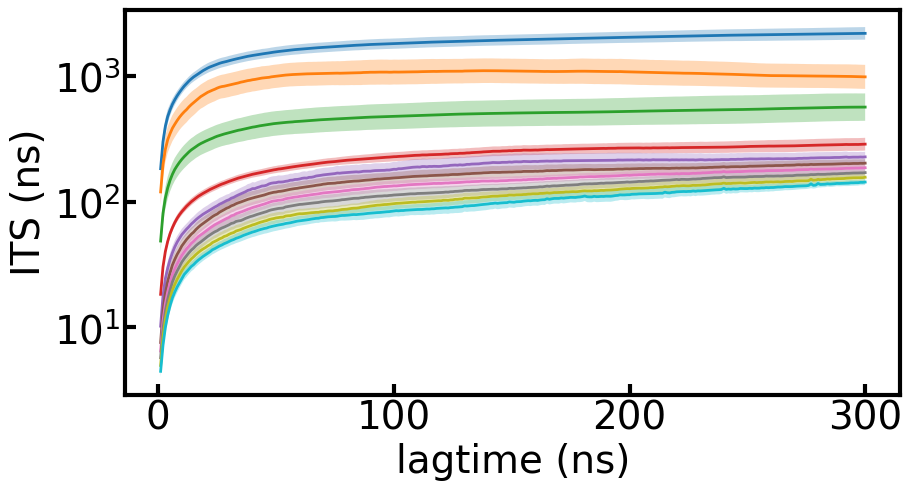

In [19]:
ITS_mean = np.mean(np.log10(bootstrap_ITS*0.2), axis=0)
ITS_std = np.std(np.log10(bootstrap_ITS*0.2), axis=0)

fig, ax = plt.subplots(figsize=(10, 5))
for i in range(10):
    ax.fill_between(lagtime * 0.2, ITS_mean[:,i]-ITS_std[:,i], 
                    ITS_mean[:,i]+ITS_std[:,i], alpha=0.3)
    ax.plot(lagtime * 0.2, ITS_mean[:,i], linewidth=2)
plt.yticks([1,2,3], labels=[ '$10^1$', '$10^2$','$10^3$'])    
plt.xlabel('lagtime (ns)')
plt.ylabel('ITS (ns)')
ax.tick_params(axis='both', direction='in', width=3, length=8)
for spine in ax.spines.values():
    spine.set_linewidth(3)
# fig.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
plt.savefig('./png/its_tica.png', dpi=500, bbox_inches='tight')
plt.show()